In [1]:


import itertools
import json
import string
import numpy as np
import matplotlib.pyplot as plt

import nltk
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer 
from nltk import pos_tag
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction import text, stop_words
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfTransformer
from string import punctuation
from string import digits
from nltk.corpus import wordnet
from sklearn import metrics
from sklearn.metrics import confusion_matrix,roc_curve
from sklearn.model_selection import train_test_split
import json
import re
import pandas as pd


file =  r'../input/superbowltweet/tweets_superbowl.txt'




/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_extraction.stop_words module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_extraction.text. Anything that cannot be imported from sklearn.feature_extraction.text is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:

            
MA_aliases = ["Boston", "Massachusetts", "MA"]
WA_aliases = ["Seattle", "Washington", "WA"]

#data
tweet_text = []
#labels: 0 for MA, 1 for WA
tweet_location = []

#both
tweet_with_location=[]

with open(file, 'r') as cur_file:
    for line in cur_file:
        json_data = json.loads(line)
        location = json_data['tweet']['user']['location']
        location_found = False
        for aliases in MA_aliases:
            if aliases in location: 
                location_found = True
                tweet_text.append((json_data['tweet']['text']))
                tweet_location.append(0)
                tweet_with_location.append((json_data['tweet']['text'], 0))
                break
        if not location_found:
            for aliases in WA_aliases:
                if aliases in location: 
                    location_found = True
                    tweet_text.append((json_data['tweet']['text']))
                    tweet_location.append(1)
                    tweet_with_location.append((json_data['tweet']['text'], 1))
tweet_data = np.array(tweet_text)
print(tweet_data.shape)

(53636,)


In [3]:

# Problem Setup/Definition:
import numpy as np
np.random.seed(42)
import random
random.seed(42)


#split the dataset into train and test

x_train, x_test, y_train, y_test = train_test_split(tweet_text, tweet_location, test_size=0.2, random_state=42)


p1_count_vectorizer = CountVectorizer(min_df=3, stop_words='english')
train_doc_term_matrix = p1_count_vectorizer.fit_transform(x_train)
test_doc_term_matrix = p1_count_vectorizer.fit_transform(x_test)

print(p1_count_vectorizer)
print("\n\n" + '-'*40 + "\n\n")
# Convert doc-term to TFIDF
tfidf_transformer = TfidfTransformer()
train_tfidf = tfidf_transformer.fit_transform(train_doc_term_matrix)
test_tfidf = tfidf_transformer.fit_transform(test_doc_term_matrix)

# Report Shape/Stats of TF-IDF Matrix
print("Shape of Train TF-IDF Matix: " + str(train_tfidf.shape))
print("Shape of Test TF-IDF Matix: " + str(test_tfidf.shape))


CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=3,
                ngram_range=(1, 1), preprocessor=None, stop_words='english',
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)


----------------------------------------


Shape of Train TF-IDF Matix: (42908, 9349)
Shape of Test TF-IDF Matix: (10728, 3452)


Shape of tf-idf matrix after SVD reduction (Top 50): (42908, 50)


----------------------------------------




/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


############## Hard Margin Stats: ############### 

Accuracy: 0.691648023862789
Precision: 0.7180332371926933
Recall: 0.8064167823538485
Confusion Matrix: 
[[2192 2053]
 [1255 5228]]
F1-score: 0.7596628886951466


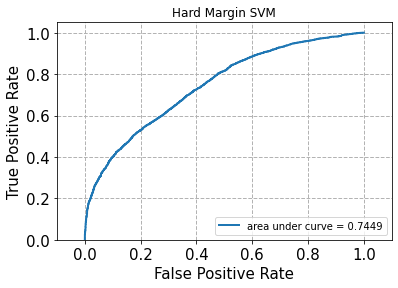



----------------------------------------




In [10]:
# Start LSI Analysis
from sklearn.decomposition import TruncatedSVD

num_terms = 50

svd_settings = TruncatedSVD(n_components=num_terms, random_state=42)
reduced_LSI_train_tfidf_matrix = svd_settings.fit_transform(train_tfidf)
reduced_LSI_test_tfidf_matrix = svd_settings.fit_transform(test_tfidf)

from sklearn.decomposition import NMF
#nmf accuracy /precision 60s, recall 80s
#nmf_settings = NMF(n_components=50, init='random', random_state=42)
#reduced_LSI_train_tfidf_matrix= nmf_settings.fit_transform(train_tfidf)
#reduced_LSI_test_tfidf_matrix = nmf_settings.fit_transform(test_tfidf)


print("Shape of tf-idf matrix after SVD reduction (Top 50): "+str(reduced_LSI_train_tfidf_matrix.shape))
print("\n\n" + '-'*40 + "\n\n")

from sklearn import metrics
from sklearn.metrics import auc
import matplotlib.pyplot as plt
from sklearn.svm import LinearSVC

def plot_roc(fpr, tpr):
    fig, ax = plt.subplots()

    roc_auc = auc(fpr,tpr)

    ax.plot(fpr, tpr, lw=2, label= 'area under curve = %0.4f' % roc_auc)

    ax.grid(color='0.7', linestyle='--', linewidth=1)

    ax.set_xlim([-0.1, 1.1])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate',fontsize=15)
    ax.set_ylabel('True Positive Rate',fontsize=15)
    
    ax.legend(loc="lower right")
    ax.title.set_text(title)

    for label in ax.get_xticklabels()+ax.get_yticklabels():
        label.set_fontsize(15)

    plt.ion()
    plt.show()
    
hard_margin_svm = LinearSVC(loss='hinge',C=1000).fit(reduced_LSI_train_tfidf_matrix, y_train)
hard_margin_svm_prediction = hard_margin_svm.predict(reduced_LSI_test_tfidf_matrix)

h_accuracy = metrics.accuracy_score(y_test, hard_margin_svm_prediction)
h_precision = metrics.precision_score(y_test, hard_margin_svm_prediction)
h_recall = metrics.recall_score(y_test, hard_margin_svm_prediction)
h_f1 = 2 * (h_precision * h_recall) / (h_precision + h_recall)
print("############## Hard Margin Stats: ############### \n")
print("Accuracy: " + str(h_accuracy))
print("Precision: " + str(h_precision))
print("Recall: " + str(h_recall))
print("Confusion Matrix: \n" + str(metrics.confusion_matrix(y_test, hard_margin_svm_prediction)))
print("F1-score: "+ str(h_f1))

# ROC Curve
dec_function_score = hard_margin_svm.decision_function(reduced_LSI_test_tfidf_matrix)
fpr, tpr, thresholds = metrics.roc_curve(y_test, dec_function_score)
plot_roc(fpr,tpr)
print("\n\n" + '-'*40 + "\n\n")      


In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import GridSearchCV
import math 

# Define & train Logistic Regression models with L1 (Lasso) & L2 (Ridge) Regularization
log_reg_l1_trained = LogisticRegression(penalty='l1',random_state=0, solver='liblinear', max_iter=5000).fit(reduced_LSI_train_tfidf_matrix, y_train)
log_reg_l2_trained = LogisticRegression(penalty='l2',random_state=0, solver='liblinear', max_iter=5000).fit(reduced_LSI_train_tfidf_matrix, y_train)

# Defining how to split the data set; k-fold, k=5
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)

# Create a Dictionary with key 'C' and value [10^-3  < k < 3]
hyper_param_range = {'C': [math.pow(10, k) for k in range(-3,4)]}
print("Hyper parameter values that will be tested: \n" + str(hyper_param_range))
print("\n\n" + '-'*40 + "\n\n")  

# Perform grid_search to find the best value of 'C'
l1_grid_search = GridSearchCV(log_reg_l1_trained, hyper_param_range, cv=5, scoring='accuracy')
l2_grid_search = GridSearchCV(log_reg_l2_trained, hyper_param_range, cv=5, scoring='accuracy')

l1_grid_search.fit(reduced_LSI_train_tfidf_matrix, y_train)
l2_grid_search.fit(reduced_LSI_train_tfidf_matrix, y_train)

##############################################
#### Print Findings L1-Logistic Regression ###
##############################################
# Print out tested parameter values (C=[0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]) vs. mean vs. std
l1_grid_mean = l1_grid_search.cv_results_['mean_test_score']
l1_grid_std =  l1_grid_search.cv_results_['std_test_score']
l1_grid_params =  l1_grid_search.cv_results_['params']

print("L1 Logistic Regression")
print("Average Accuracy vs. C-value: \n")
for mean, standard_dev, hyper_param_values in zip(l1_grid_mean, l1_grid_std, l1_grid_params):
    print("Mean: " + str(mean) + "    std: " + str(standard_dev) + "   C: " + str(hyper_param_values))
print("\n\n" + '-'*40 + "\n\n") 

##############################################
#### Print Findings L2-Logistic Regression ###
##############################################
# Print out tested parameter values (C=[0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]) vs. mean vs. std
l2_grid_mean = l2_grid_search.cv_results_['mean_test_score']
l2_grid_std =  l2_grid_search.cv_results_['std_test_score']
l2_grid_params =  l2_grid_search.cv_results_['params']

print("L2 Logistic Regression")
print("Average Accuracy vs. C-value: \n")
for mean, standard_dev, hyper_param_values in zip(l2_grid_mean, l2_grid_std, l2_grid_params):
    print("Mean: " + str(mean) + "    std: " + str(standard_dev) + "   C: " + str(hyper_param_values))
print("\n\n" + '-'*40 + "\n\n")

Hyper parameter values that will be tested: 
{'C': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]}


----------------------------------------


L1 Logistic Regression
Average Accuracy vs. C-value: 

Mean: 0.6049687691050595    std: 2.255168033551881e-05   C: {'C': 0.001}
Mean: 0.7168360882278519    std: 0.003601364756856828   C: {'C': 0.01}
Mean: 0.7424956460391932    std: 0.004355145782718068   C: {'C': 0.1}
Mean: 0.7471800507921131    std: 0.004763032128252841   C: {'C': 1.0}
Mean: 0.7475995714519004    std: 0.004339814543670802   C: {'C': 10.0}
Mean: 0.747576266860896    std: 0.004331228101038707   C: {'C': 100.0}
Mean: 0.7475995741677367    std: 0.004349031545575894   C: {'C': 1000.0}


----------------------------------------


L2 Logistic Regression
Average Accuracy vs. C-value: 

Mean: 0.6049687718208958    std: 6.159967982428815e-05   C: {'C': 0.001}
Mean: 0.7010347987976775    std: 0.0017308905905110172   C: {'C': 0.01}
Mean: 0.7392328647909236    std: 0.004324242432604343   C: 

In [12]:
def plot_roc(fpr, tpr):
    fig, ax = plt.subplots()

    roc_auc = auc(fpr,tpr)

    ax.plot(fpr, tpr, lw=2, label= 'area under curve = %0.4f' % roc_auc)

    ax.grid(color='0.7', linestyle='--', linewidth=1)

    ax.set_xlim([-0.1, 1.1])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate',fontsize=15)
    ax.set_ylabel('True Positive Rate',fontsize=15)

    ax.legend(loc="lower right")

    for label in ax.get_xticklabels()+ax.get_yticklabels():
        label.set_fontsize(15)

############## Log Regression (NO REGULARIZATION!): ############### 

Accuracy: 0.6777591349739001
Precision: 0.7452188006482983
Recall: 0.7092395495912386
Confusion Matrix: 
[[2673 1572]
 [1885 4598]]
F1-score: 0.7267841618588478
############## Log Regression (OPTIMAL L1!): ############### 

Accuracy: 0.6778523489932886
Precision: 0.7452600875060769
Recall: 0.7093937991670523
Confusion Matrix: 
[[2673 1572]
 [1884 4599]]
F1-score: 0.7268847795163584
############## Log Regression (OPTIMAL L2!): ############### 

Accuracy: 0.6774794929157345
Precision: 0.7450153995785378
Recall: 0.7089310504396112
Confusion Matrix: 
[[2672 1573]
 [1887 4596]]
F1-score: 0.7265254505216566


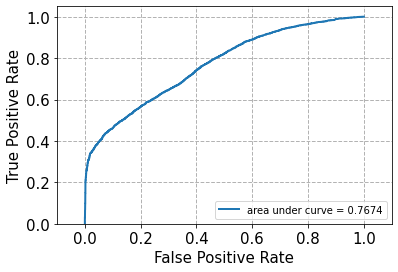

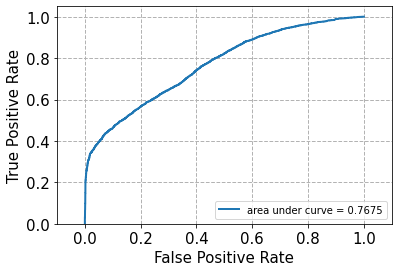

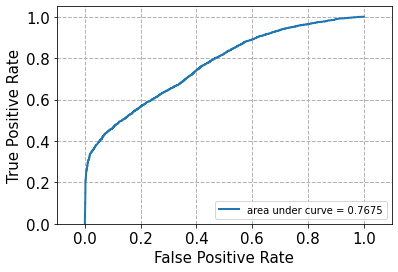

In [13]:
log_reg_trained = LogisticRegression(penalty='none',random_state=0, solver='lbfgs', max_iter=5000).fit(reduced_LSI_train_tfidf_matrix, y_train)
log_reg_predicted = log_reg_trained.predict(reduced_LSI_test_tfidf_matrix)

################################################
#### Logistic Regrssion - Optimal 'C' values  ##
################################################
optimal_log_l1_trained = LogisticRegression(penalty='l1', C=100, random_state=0, solver='liblinear', max_iter=5000).fit(reduced_LSI_train_tfidf_matrix, y_train)
optimal_log_l2_trained = LogisticRegression(penalty='l2', C=100, random_state=0, solver='liblinear', max_iter=5000).fit(reduced_LSI_train_tfidf_matrix, y_train)

# Make Predictions using both l1 & l2 optimal 'C' values
optimal_log_l1_predicted = optimal_log_l1_trained.predict(reduced_LSI_test_tfidf_matrix)
optimal_log_l2_predicted = optimal_log_l2_trained.predict(reduced_LSI_test_tfidf_matrix)

################################
#### Print & Compare Results ###
################################
log_accuracy = metrics.accuracy_score(y_test, log_reg_predicted)
log_precision = metrics.precision_score(y_test, log_reg_predicted)
log_recall = metrics.recall_score(y_test, log_reg_predicted)
log_f1 = 2 * (log_precision * log_recall) / (log_precision + log_recall)
print("############## Log Regression (NO REGULARIZATION!): ############### \n")
print("Accuracy: " + str(log_accuracy))
print("Precision: " + str(log_precision))
print("Recall: " + str(log_recall))
print("Confusion Matrix: \n" + str(metrics.confusion_matrix(y_test, log_reg_predicted)))
print("F1-score: "+ str(log_f1))

# ROC Curve
dec_function_score = log_reg_trained.predict_proba(reduced_LSI_test_tfidf_matrix)
fpr, tpr, thresholds = metrics.roc_curve(y_test, dec_function_score[:,1])
plot_roc(fpr,tpr)

#########################
optimal_l1_log_accuracy = metrics.accuracy_score(y_test, optimal_log_l1_predicted)
optimal_l1_log_precision = metrics.precision_score(y_test, optimal_log_l1_predicted)
optimal_l1_log_recall = metrics.recall_score(y_test, optimal_log_l1_predicted)
optimal_l1_log_f1 = 2 * (optimal_l1_log_precision * optimal_l1_log_recall) / (optimal_l1_log_precision + optimal_l1_log_recall)
print("############## Log Regression (OPTIMAL L1!): ############### \n")
print("Accuracy: " + str(optimal_l1_log_accuracy))
print("Precision: " + str(optimal_l1_log_precision))
print("Recall: " + str(optimal_l1_log_recall))
print("Confusion Matrix: \n" + str(metrics.confusion_matrix(y_test, optimal_log_l1_predicted)))
print("F1-score: "+ str(optimal_l1_log_f1))

# ROC Curve
dec_function_score = optimal_log_l1_trained.predict_proba(reduced_LSI_test_tfidf_matrix)
fpr, tpr, thresholds = metrics.roc_curve(y_test, dec_function_score[:,1])
plot_roc(fpr,tpr)

##########################

optimal_l2_log_accuracy = metrics.accuracy_score(y_test, optimal_log_l2_predicted)
optimal_l2_log_precision = metrics.precision_score(y_test, optimal_log_l2_predicted)
optimal_l2_log_recall = metrics.recall_score(y_test, optimal_log_l2_predicted)
optimal_l2_log_f1 = 2 * (optimal_l2_log_precision * optimal_l2_log_recall) / (optimal_l2_log_precision + optimal_l2_log_recall)
print("############## Log Regression (OPTIMAL L2!): ############### \n")
print("Accuracy: " + str(optimal_l2_log_accuracy))
print("Precision: " + str(optimal_l2_log_precision))
print("Recall: " + str(optimal_l2_log_recall))
print("Confusion Matrix: \n" + str(metrics.confusion_matrix(y_test, optimal_log_l2_predicted)))
print("F1-score: "+ str(optimal_l2_log_f1))

# ROC Curve
dec_function_score = optimal_log_l2_trained.predict_proba(reduced_LSI_test_tfidf_matrix)
fpr, tpr, thresholds = metrics.roc_curve(y_test, dec_function_score[:,1])
plot_roc(fpr,tpr)

############## Naive Bayes: Gauss Stats ############### 

Accuracy: 0.5804436987322893
Precision: 0.6635313531353135
Recall: 0.620237544346753
Confusion Matrix: 
[[2206 2039]
 [2462 4021]]
F1-score: [0.5080083 0.5080083 0.5080083 ... 0.5080083 0.5080083 0.5080083]


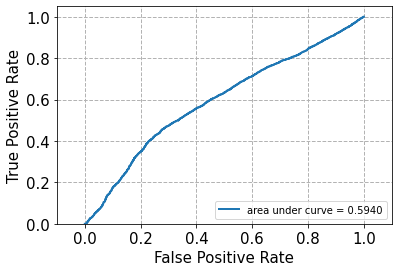

In [14]:
#naive bayes
from sklearn.naive_bayes import GaussianNB

train_gauss_model = GaussianNB().fit(reduced_LSI_train_tfidf_matrix, y_train)
predict_gauss_model = train_gauss_model.predict(reduced_LSI_test_tfidf_matrix)

# Plot Gaus Model Statistics:
gauss_accuracy = metrics.accuracy_score(y_test, predict_gauss_model)
gauss_precision = metrics.precision_score(y_test, predict_gauss_model)
gauss_recall = metrics.recall_score(y_test, predict_gauss_model)
gauss_f1 = 2 * (gauss_precision * gauss_recall) / (predict_gauss_model + gauss_recall)
print("############## Naive Bayes: Gauss Stats ############### \n")
print("Accuracy: " + str(gauss_accuracy))
print("Precision: " + str(gauss_precision))
print("Recall: " + str(gauss_recall))
print("Confusion Matrix: \n" + str(metrics.confusion_matrix(y_test, predict_gauss_model)))
print("F1-score: "+ str(gauss_f1))

# ROC Curve
dec_function_score = train_gauss_model.predict_proba(reduced_LSI_test_tfidf_matrix)
fpr, tpr, thresholds = metrics.roc_curve(y_test, dec_function_score[:,1])
plot_roc(fpr,tpr)

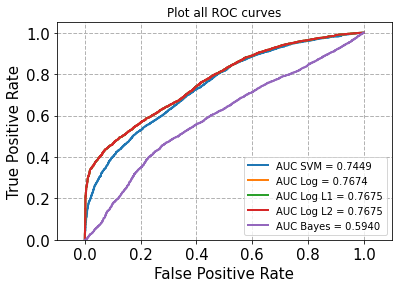

In [23]:
# plot all ROC curves

def plot_all_roc(fpr_a, tpr_a, fpr_b, tpr_b, fpr_c, tpr_c, fpr_d, tpr_d, fpr_e, tpr_e, title):
    fig, ax = plt.subplots()

    roc_auc_a = auc(fpr_a,tpr_a)
    roc_auc_b = auc(fpr_b,tpr_b)
    roc_auc_c = auc(fpr_c,tpr_c)
    roc_auc_d = auc(fpr_d,tpr_d)
    roc_auc_e = auc(fpr_e,tpr_e)

    ax.plot(fpr_a, tpr_a, lw=2, label= 'AUC SVM = %0.4f' % roc_auc_a)
    ax.plot(fpr_b, tpr_b, lw=2, label= 'AUC Log = %0.4f' % roc_auc_b)
    ax.plot(fpr_c, tpr_c, lw=2, label= 'AUC Log L1 = %0.4f' % roc_auc_c)
    ax.plot(fpr_d, tpr_d, lw=2, label= 'AUC Log L2 = %0.4f' % roc_auc_d)
    ax.plot(fpr_e, tpr_e, lw=2, label= 'AUC Bayes = %0.4f' % roc_auc_e)

    ax.grid(color='0.7', linestyle='--', linewidth=1)

    ax.set_xlim([-0.1, 1.1])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate',fontsize=15)
    ax.set_ylabel('True Positive Rate',fontsize=15)
    
    ax.legend(loc="lower right")
    ax.title.set_text(title)

    for label in ax.get_xticklabels()+ax.get_yticklabels():
        label.set_fontsize(15)

    plt.ion()
    plt.show()
    
dec_function_score = hard_margin_svm.decision_function(reduced_LSI_test_tfidf_matrix)
fpr, tpr, thresholds = metrics.roc_curve(y_test, dec_function_score)

dec_function_score = log_reg_trained.predict_proba(reduced_LSI_test_tfidf_matrix)
fpr_f, tpr_f, thresholds = metrics.roc_curve(y_test, dec_function_score[:,1])

dec_function_score = optimal_log_l1_trained.predict_proba(reduced_LSI_test_tfidf_matrix)
fpr_g, tpr_g, thresholds = metrics.roc_curve(y_test, dec_function_score[:,1])

dec_function_score = optimal_log_l2_trained.predict_proba(reduced_LSI_test_tfidf_matrix)
fpr_h, tpr_h, thresholds = metrics.roc_curve(y_test, dec_function_score[:,1])

dec_function_score = train_gauss_model.predict_proba(reduced_LSI_test_tfidf_matrix)
fpr_i, tpr_i, thresholds = metrics.roc_curve(y_test, dec_function_score[:,1])


plot_all_roc(fpr,tpr,fpr_f,tpr_f, fpr_g, tpr_g, fpr_h, tpr_h, fpr_i, tpr_i, 'Plot all ROC curves')


#Log, L1, L2 all pretty similar results

In [ ]:
#comment